In [24]:
#%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
from collections import Counter
import seaborn as sn

sn.set_theme()

In [2]:
%%time
datasetPath = "../dataset/users_clean_with_indicators_with_outliers.h5"
df_users = pd.read_hdf(datasetPath)

CPU times: total: 93.8 ms
Wall time: 120 ms


In [3]:
df_users.head()

,name,lang,bot,created_at,statuses_count,tweet_count,retweet_count_avg,reply_count_avg,favorite_count_avg,num_hashtags_avg,...,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,retweet_count_entropy,reply_count_entropy,favorite_count_entropy,num_hashtags_entropy,num_mentions_entropy
2353593986,lamonica raborn,en,1,2019-02-22 18:00:42,76.0,127,0.039370,0.0,0.039370,0.102362,...,0,5,13,0,35,1.609438,0.0,1.609438,1.951260,3.555348
2358850842,lourie botton,en,0,2019-02-26 03:02:32,54.0,116,0.025862,0.0,0.051724,0.025862,...,0,6,3,0,41,1.098612,0.0,1.791759,1.098612,3.713572
137959629,dadan syarifudin,en,1,2015-04-30 07:09:56,3.0,3,0.000000,0.0,0.000000,0.000000,...,0,0,0,0,0,0.000000,0.0,0.000000,0.000000,0.000000
466124818,carletto focia,it,1,2017-01-18 02:49:18,50.0,1378,0.861393,0.0,0.185051,0.080552,...,0,255,111,35,9,2.164284,0.0,5.155743,3.993476,1.831020
2571493866,mbk ebook,en,0,2019-06-18 19:30:21,7085.0,3506,0.017399,0.0,0.063605,0.129492,...,0,223,454,3,1832,3.965939,0.0,5.332573,5.842069,7.339108


In [4]:
df_bot = df_users.bot.copy()

In [5]:
df_users.dtypes

name                              object
lang                              object
bot                                int64
created_at                datetime64[ns]
statuses_count                   float64
tweet_count                        int64
retweet_count_avg                float64
reply_count_avg                  float64
favorite_count_avg               float64
num_hashtags_avg                 float64
num_urls_avg                     float64
num_mentions_avg                 float64
tweet_length_avg                 float64
num_special_chars_avg            float64
retweet_count                      int64
reply_count                        int64
favorite_count                     int64
num_hashtags                       int64
num_urls                           int64
num_mentions                       int64
retweet_count_entropy            float64
reply_count_entropy              float64
favorite_count_entropy           float64
num_hashtags_entropy             float64
num_mentions_ent

In [6]:
# delete categorical attributes
del df_users['name']
del df_users['lang']
del df_users['bot']
del df_users['created_at']

In [7]:
df_users.describe()

,statuses_count,tweet_count,retweet_count_avg,reply_count_avg,favorite_count_avg,num_hashtags_avg,num_urls_avg,num_mentions_avg,tweet_length_avg,num_special_chars_avg,...,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,retweet_count_entropy,reply_count_entropy,favorite_count_entropy,num_hashtags_entropy,num_mentions_entropy
count,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,...,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000
mean,5750.093500,940.685871,362.744886,0.369431,17.567901,0.154632,0.090168,0.360214,69.420737,5.618642,...,230.172402,2150.310393,159.894334,151.227146,492.222193,1.928334,0.112597,2.611871,2.666329,3.420989
std,18752.596595,1227.536451,2180.431575,7.723115,362.633067,0.230345,0.181239,0.367936,16.519805,5.589786,...,3878.299781,27870.387975,482.533814,397.999724,1003.377872,1.716214,0.435810,2.306260,1.933728,2.603358
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,65.000000,0.023810,0.000000,0.024031,0.050000,0.000000,0.010623,60.634728,3.722736,...,0.000000,3.000000,5.000000,0.000000,2.000000,0.288095,0.000000,0.636514,1.332179,0.693147
50%,71.000000,132.000000,0.108611,0.000000,0.064698,0.085106,0.017844,0.315385,66.760846,4.500412,...,0.000000,10.000000,11.000000,1.000000,36.000000,1.609438,0.000000,1.945910,2.055979,3.583519
75%,2520.250000,1700.000000,117.474227,0.000000,0.269265,0.170313,0.078116,0.524956,78.873718,5.709773,...,0.000000,401.000000,115.000000,83.000000,431.000000,3.124181,0.000000,4.835514,4.233378,5.794776
max,399555.000000,3926.000000,63995.214286,621.666667,22559.916667,6.430140,2.000000,5.782609,245.000000,145.500000,...,200000.000000,924928.000000,16982.000000,3900.000000,13998.000000,7.992865,7.069189,8.019666,8.135237,8.123727


Apply log scale

In [8]:
df_users.skew()

statuses_count             8.312859
tweet_count                1.109770
retweet_count_avg         17.759911
reply_count_avg           56.794175
favorite_count_avg        36.326713
num_hashtags_avg           5.871566
num_urls_avg               3.055984
num_mentions_avg           1.629930
tweet_length_avg           1.127443
num_special_chars_avg      8.474113
retweet_count             15.107382
reply_count               33.587473
favorite_count            25.996905
num_hashtags              10.293280
num_urls                   3.956451
num_mentions               3.126577
retweet_count_entropy      0.665673
reply_count_entropy        6.126501
favorite_count_entropy     0.481576
num_hashtags_entropy       0.508044
num_mentions_entropy       0.129363
dtype: float64

In [9]:
df_users.statuses_count = np.log(df_users.statuses_count + 1)
df_users.tweet_count = np.log(df_users.tweet_count + 1)
df_users.retweet_count_avg = np.log(df_users.retweet_count_avg + 1)
df_users.reply_count_avg = np.log(df_users.reply_count_avg + 1)
df_users.favorite_count_avg = np.log(df_users.favorite_count_avg + 1)
df_users.num_hashtags_avg = np.log(df_users.num_hashtags_avg + 1)
df_users.num_urls_avg = np.log(df_users.num_urls_avg + 1)
df_users.num_mentions_avg = np.log(df_users.num_mentions_avg + 1)
df_users.tweet_length_avg = np.log(df_users.tweet_length_avg + 1)
df_users.num_special_chars_avg = np.log(df_users.num_special_chars_avg + 1)
df_users.retweet_count = np.log(df_users.retweet_count + 1)
df_users.reply_count = np.log(df_users.reply_count + 1)
df_users.favorite_count = np.log(df_users.favorite_count + 1)
df_users.num_hashtags = np.log(df_users.num_hashtags + 1)
df_users.num_urls = np.log(df_users.num_urls + 1)
df_users.num_mentions = np.log(df_users.num_mentions + 1)
df_users.reply_count_entropy = np.log(df_users.reply_count_entropy + 1)

In [10]:
df_users.describe()

,statuses_count,tweet_count,retweet_count_avg,reply_count_avg,favorite_count_avg,num_hashtags_avg,num_urls_avg,num_mentions_avg,tweet_length_avg,num_special_chars_avg,...,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,retweet_count_entropy,reply_count_entropy,favorite_count_entropy,num_hashtags_entropy,num_mentions_entropy
count,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,...,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000
mean,5.606388,5.471644,2.216404,0.062541,0.321513,0.130390,0.075577,0.275798,4.226998,1.772996,...,0.528223,3.459341,3.096227,2.229404,3.627749,1.928334,0.069067,2.611871,2.666329,3.420989
std,2.634090,1.926702,2.751950,0.327954,0.843355,0.150713,0.138135,0.245668,0.240840,0.404587,...,1.560948,2.778970,2.001622,2.505322,2.642986,1.716214,0.233844,2.306260,1.933728,2.603358
min,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.386294,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.761200,4.189655,0.023530,0.000000,0.023746,0.048790,0.000000,0.010567,4.121225,1.552388,...,0.000000,1.386294,1.791759,0.000000,1.098612,0.288095,0.000000,0.636514,1.332179,0.693147
50%,4.276666,4.890349,0.103108,0.000000,0.062691,0.081678,0.017687,0.274129,4.215985,1.704823,...,0.000000,2.397895,2.484907,0.693147,3.610918,1.609438,0.000000,1.945910,2.055979,3.583519
75%,7.832510,7.438972,4.774695,0.000000,0.238438,0.157271,0.075215,0.421966,4.380447,1.903565,...,0.000000,5.996452,4.753590,4.430817,6.068426,3.124181,0.000000,4.835514,4.233378,5.794776
max,12.898109,8.275631,11.066579,6.434011,10.023974,2.005545,1.098612,1.914362,5.505332,4.987025,...,12.206078,13.737472,9.739968,8.268988,9.546741,7.992865,2.088053,8.019666,8.135237,8.123727


In [11]:
df_users.head()

,statuses_count,tweet_count,retweet_count_avg,reply_count_avg,favorite_count_avg,num_hashtags_avg,num_urls_avg,num_mentions_avg,tweet_length_avg,num_special_chars_avg,...,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,retweet_count_entropy,reply_count_entropy,favorite_count_entropy,num_hashtags_entropy,num_mentions_entropy
2353593986,4.343805,4.852030,0.038615,0.0,0.038615,0.097455,0.000000,0.243409,4.165260,1.599944,...,0.0,1.791759,2.639057,0.000000,3.583519,1.609438,0.0,1.609438,1.951260,3.555348
2358850842,4.007333,4.762174,0.025533,0.0,0.050431,0.025533,0.000000,0.302656,4.258055,1.504077,...,0.0,1.945910,1.386294,0.000000,3.737670,1.098612,0.0,1.791759,1.098612,3.713572
137959629,1.386294,1.386294,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.908721,1.673976,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
466124818,3.931826,7.229114,0.621325,0.0,0.169786,0.077472,0.025082,0.006510,4.494514,1.761056,...,0.0,5.545177,4.718499,3.583519,2.302585,2.164284,0.0,5.155743,3.993476,1.831020
2571493866,8.865876,8.162516,0.017249,0.0,0.061664,0.121768,0.000855,0.420375,4.314361,1.541158,...,0.0,5.411646,6.120297,1.386294,7.513709,3.965939,0.0,5.332573,5.842069,7.339108


In [42]:
def knn_dist_graph(X):
    klist = [3, 6, 9, 12]
    dist = pdist(X, 'euclidean') #pair wise distance
    dist = squareform(dist) #distance matrix given the vector dist
    
    # Calculate sorted list of distances for points for each k
    for k in klist:
        kth_distances = list()
        for d in dist:
            index_kth_distance = np.argsort(d)[k]
            kth_distances.append(d[index_kth_distance])

        # Plot the graph of distance from k-th nearest neighbour
        plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
        plt.ylabel('dist from %sth neighbor' % k)
        plt.xlabel('sorted distances')
        plt.tick_params(axis='both', which='major')
        plt.grid()
        plt.show()


Best silhouette_score: 0.11595320345885173
min_samples: 15
eps: 0.2


## MinMax

In [13]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(df_users.values)

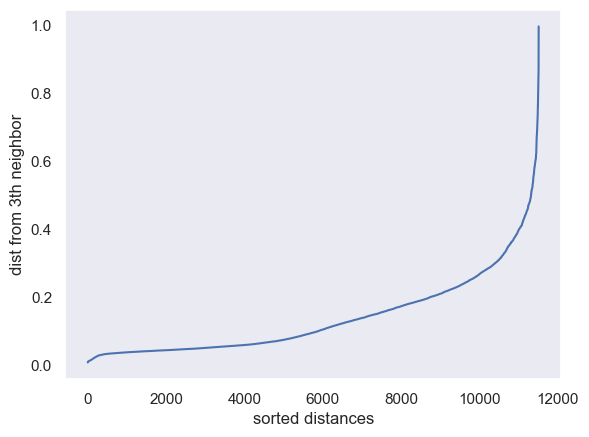

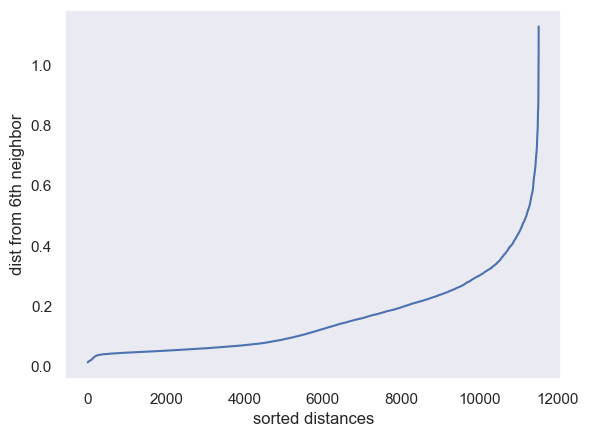

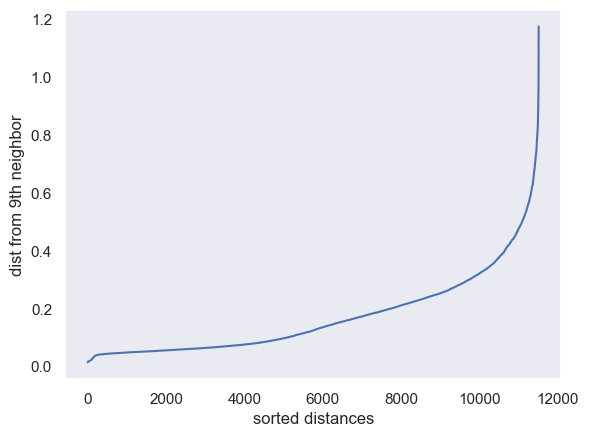

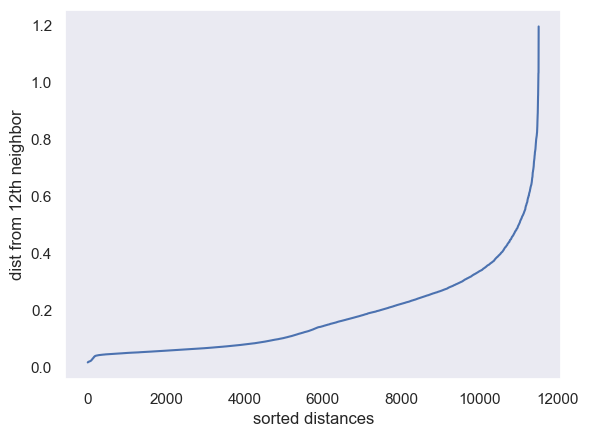

In [32]:
knn_dist_graph(X_minmax)

In [ ]:
min_samples = np.arange(3, 21, 3)
# array of ranging from 0.1 to 0.6 with step of 0.1
eps_list = np.arange(0.2, 0.6, 0.1)
output = []
for ms in min_samples:
    for eps in eps_list:
        labels = DBSCAN(min_samples=ms, eps=eps).fit(df_users).labels_
        score = silhouette_score(df_users, labels)
        output.append((ms, eps, score))

min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]
print(f"Best silhouette_score: {score}")
print(f"min_samples: {min_samples}")
print(f"eps: {eps}")

In [20]:
dbscan = DBSCAN(min_samples=min_samples, eps=eps).fit(df_users).labels_
clusters = len(Counter(dbscan))
print(f"Number of clusters: {clusters}")
print(f"Number of outliers: {Counter(dbscan)[-1]}")
print(f"Silhouette_score: {silhouette_score(df_users, dbscan)}")

Number of clusters: 2
Number of outliers: 11461
Silhouette_score: 0.1129751844612434


In [34]:
if 'labels' in df_users.columns:
    del df_users['labels']
df_users['labels'] = pd.Series(dbscan, index=df_users.index)

<AxesSubplot:xlabel='favorite_count', ylabel='tweet_count'>

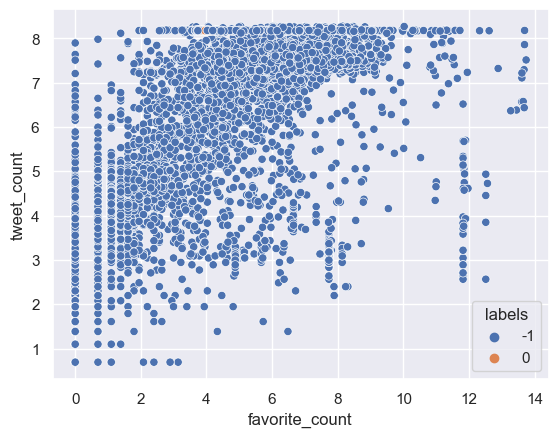

In [37]:
sn.scatterplot(data=df_users, x="favorite_count", y="tweet_count", hue="labels", palette=sn.color_palette(n_colors=clusters))

## Standard Scaler

In [39]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df_users.values)

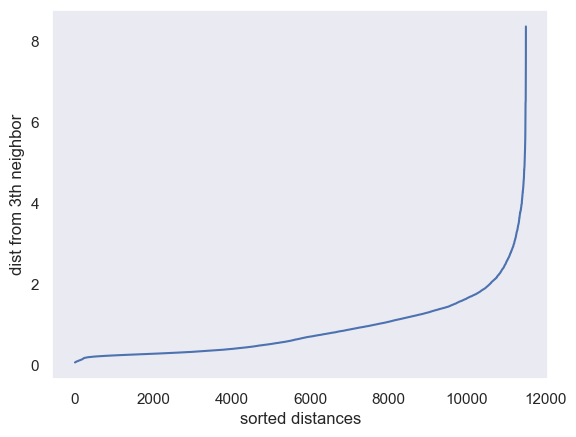

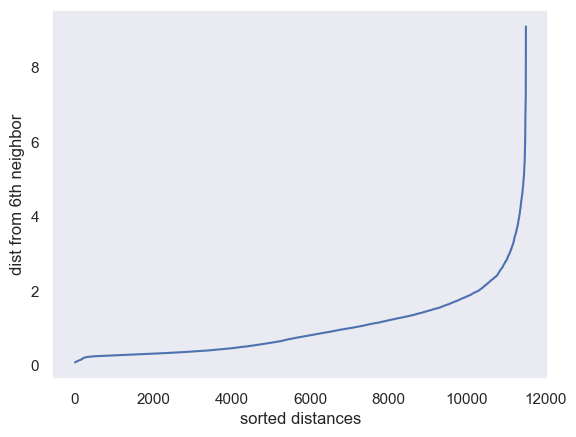

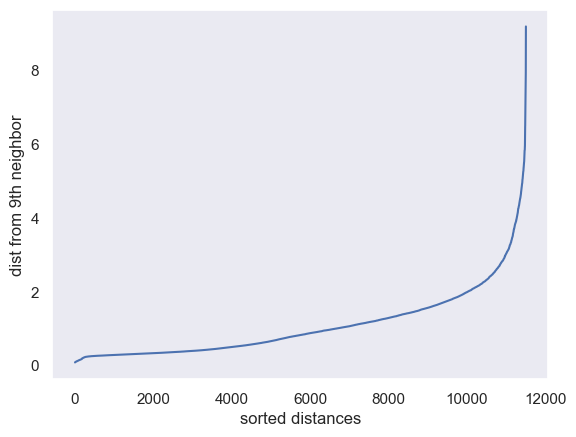

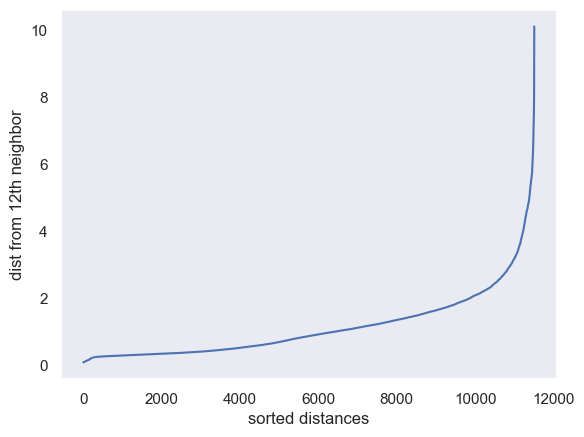

In [41]:
knn_dist_graph(X_std)

In [43]:
min_samples = np.arange(3, 21, 3)
# array of ranging from 1 to 4 with step of 0.5
eps_list = np.arange(1, 4, 0.5)
output = []
for ms in min_samples:
    for eps in eps_list:
        labels = DBSCAN(min_samples=ms, eps=eps).fit(df_users).labels_
        score = silhouette_score(df_users, labels)
        output.append((ms, eps, score))

min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]
print(f"Best silhouette_score: {score}")
print(f"min_samples: {min_samples}")
print(f"eps: {eps}")

Best silhouette_score: 0.18691970460825338
min_samples: 12
eps: 1.5


In [44]:
dbscan = DBSCAN(min_samples=min_samples, eps=eps).fit(df_users).labels_
clusters = len(Counter(dbscan))
print(f"Number of clusters: {clusters}")
print(f"Number of outliers: {Counter(dbscan)[-1]}")
print(f"Silhouette_score: {silhouette_score(df_users, dbscan)}")

Number of clusters: 21
Number of outliers: 3635
Silhouette_score: 0.18691970460825338


<AxesSubplot:xlabel='tweet_length_avg', ylabel='tweet_count'>

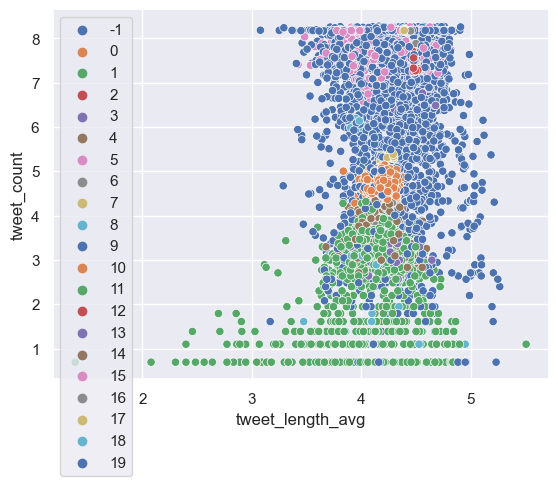

In [50]:
sn.scatterplot(data=df_users, x="tweet_length_avg", y="tweet_count", hue=dbscan, palette=sn.color_palette(n_colors=clusters))

In [ ]:
# plt.scatter(df_users['favorite_count'], df_users['tweet_count'], c=dbscan, s=20)
# plt.tick_params(axis='both', which='major')
# plt.show()
# sn.pairplot(data=df_users, hue="labels", palette=sn.color_palette(n_colors=clusters))

# KMeans

In [23]:
sse_list = list()
separations = list()
silouettes_ = list()

max_k = 25
for k in tqdm(range(2, max_k + 1)):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X)
    
    sse = kmeans.inertia_
    sse_list.append(sse)
    separations.append(metrics.davies_bouldin_score(X, kmeans.labels_))
    silouettes_.append(silhouette_score(X, kmeans.labels_))

NameError: name 'tqdm' is not defined

In [ ]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.xticks(range(2, len(sse_list) + 2))
plt.savefig("images/clustering/kmeans_sse.png")
plt.show()

In [ ]:
plt.plot(range(2, len(separations) + 2), separations)
plt.ylabel('Separation', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.xticks(range(2, len(separations) + 2))
plt.savefig("images/clustering/kmeans_separation.png")
plt.show()

In [ ]:
plt.plot(range(2, len(silouettes_) + 2), silouettes_)
plt.ylabel('Silouettes', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.xticks(range(2, len(silouettes_) + 2))
plt.savefig("images/clustering/kmeans_silouettes.png")
plt.show()

In [ ]:
selected_k=21
kmeans = KMeans(n_clusters=selected_k, n_init=100, max_iter=500)
kmeans.fit(X)